# Projeto final de processamento de imagens
## Relatório parcial

Alunos:
- Akihito- 10692082
- Lucas Xavier Ebling Pereira - 10692183
- Luís Felipe Ribeiro Chaves - 10801221
- Henrique - 10692210

### Explicação geral do que é feito neste notebook

O objetivo deste código é extrair áreas de floresta de imagens de satélite para que seja possível comparar a mudança da vegetação com o tempo e detectar regiões de desmantamento ou reflorestação.

As operações realizadas para alcançar tal objetivo são:
1. A imagem alvo é lida no modelo de cor RGB
2. A imagem alvo é convertida para o modelo HLS
3. A imagem é binarizada seguindo o seguinte critério:
    - O valor 1 é assinalado para todas regiões com hue entre 110 e 200 (considerando um hue no intervalo 0-360), que representa a cor verde, e luminance inferior a cerca 25%, que representa cores escuras. Ou seja, é atribuído o valor 1 para todos os pixels verde-escuro
    - O valor 0 é assinalado aos demais pixels
4. É realizado uma operação de opening para reduzir áreas isoladas que são verde-escuras.
5. É realizado uma operação de closing para unificar regiões com muitos pixels verde-escuros mas que possuem 'buracos'

Imports das bibliotecas utilizadas para realização do filtro

In [98]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import label

Leitura da imagem de input. Observe que a biblioteca cv2 realiza a leitura da imagem no modelo BGR. Para evitar confusões, estamos convertendo as imagens para RGB após a leitura

In [99]:
img_path = './amazonia/input.png'

img = cv2.imread('input.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

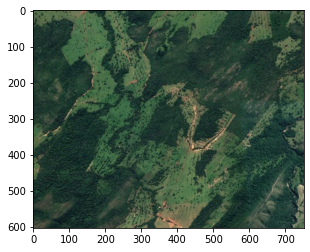

In [100]:
plt.imshow(img)

Aplicamos um filtro gaussiano 5x5 de desvio padrão .5 para embaçar levemente a imagem para suprimir pequenos ruídos.

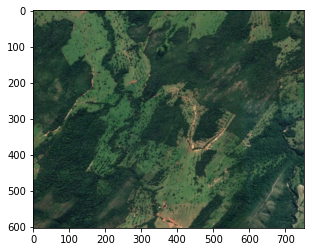

In [101]:
blur_img = cv2.GaussianBlur(img, (5, 5), .5)
plt.imshow(blur_img)

Convertemos a imagem de RGB para HSL

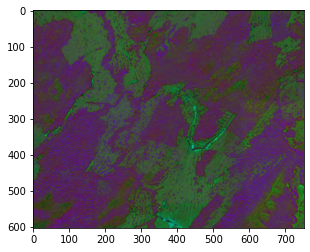

In [102]:
hls_img = cv2.cvtColor(blur_img, cv2.COLOR_RGB2HLS)
plt.imshow(hls_img)

Na biblioteca cv2, os valores do HSL possuem os seguintes ranges:

- Hue: [0-179] (360//2 valores)
- Luminance: [0-255]
- Saturation: [0-255]

Dessa forma, para binarizar o mapa em regiões verde-escuras e regiões de outras cores, basta utilizar a função inRange do cv2, estabelecendo os limites da cor desejada. 

No caso, a cor verde é representada por um Hue de 54 a 100 e uma tonalidade escura é representada por uma Luminance baixa (escolhemos o valor 60). 

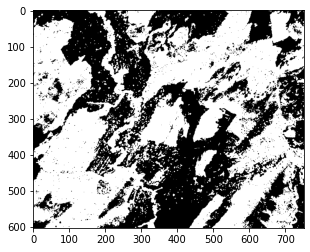

In [103]:
# https://stackoverflow.com/questions/10948589/choosing-the-correct-upper-and-lower-hsv-boundaries-for-color-detection-withcv

GREEN_MIN = np.array([54, 0, 0],np.uint8) # 0-360 110-200 0-179 54-100
GREEN_MAX = np.array([100, 60, 255],np.uint8)

green_img = cv2.inRange(hls_img, GREEN_MIN, GREEN_MAX)
# cv2.imwrite('output.png', green_img)
plt.imshow(green_img, cmap='gray')

Por fim, com o intuito de remover alguns ruídos de cores verde-escura isolada ou de cores não verde-escuras dentro de regiões florestais (na imagem binarizada isso equivale a pontos brancos isolados ou pontos pretos em regiões brancas), iremos aplicar uma operação de opening, removendo pequenas regiões brancas do mapa e, depois uma operação de closing para remover pequenos pontos pretos dentro de regiões brancas.

Com o intuito de testar, testamos com 2 discos de tamanhos diferentes combinados. Chegamos a conclusão de que a utilização do disk2 tanto para o opening quanto para o closing obteve o melhor resultado, mas pensamos em possívelmente tentar mais variações para a próxima entrega

In [104]:
disk1 = np.array([
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
], np.uint8)

disk2 = np.array([
    [0, 0, 1, 0, 0],
    [0, 1, 1, 1, 0],
    [1, 1, 1, 1, 1],
    [0, 1, 1, 1, 0],
    [0, 0, 1, 0, 0]
], np.uint8)

disk1_img = green_img.copy()
disk2_img = green_img.copy()
disk3_img = green_img.copy()

eroded_img1 = cv2.erode(disk1_img, disk1)
dilated_img1 = cv2.dilate(eroded_img1, disk1)
# dilated_img1 = cv2.dilate(dilated_img1, disk1)
# eroded_img1 = cv2.erode(dilated_img1, disk1)
disk1_img = dilated_img1

eroded_img2 = cv2.erode(disk2_img, disk2)
dilated_img2 = cv2.dilate(eroded_img2, disk2)
# dilated_img2 = cv2.dilate(dilated_img2, disk2)
# eroded_img2 = cv2.erode(dilated_img2, disk2)
disk2_img = dilated_img2

eroded_img3 = cv2.erode(disk3_img, disk2)
dilated_img3 = cv2.dilate(eroded_img3, disk2)
# dilated_img3 = cv2.dilate(dilated_img3, disk1)
# eroded_img3 = cv2.erode(dilated_img3, disk1)
disk3_img = dilated_img3

# cv2.imwrite('output_disk1.png', disk1_img)
# cv2.imwrite('output_disk2.png', disk2_img)
# cv2.imwrite('output_disk3.png', disk3_img)

Para a próxima, pretendemos segmentar melhor áreas florestais de áreas de plantio verde-escuras. Pretendemos realizar isso analisando a variância das regiões (Áreas com grande variância costumam ser florestas devido a diferença entre texturas de folhagens e plantações). Também realizaremos tentativas de melhoria da remoção de ruídos.

Também pretendemos analisar outros técnicas que realizem essa tarefa para efeito de comparação.

Por fim, como objetivo final deste trabalho, pretendemos atribuir uma nota de vegetação para a imagem de satelite que poderá ser comparada temporalmente.

Para o desenvolvimento desse código foi utilizado esse tutorial https://clouard.users.greyc.fr/Pantheon/experiments/forestarea-extraction/index-en.html 

## Entrega final

Para esta entrega final, tentaremos desenvolver o seguinte:


*   Filtro por regiões com alta variância (idealmente por serem regiões com folhagem)
*   Remoção de regiões com áreas menores que um certo threshold para remoção de ruído



### Filtro de variância

A ideia dessa etapa é filtrar áreas com variância alta e depois fazer uma interseção do resultado com o que foi obtido no final da etapa 2. Era esperado um bom resultado pelo fato de áreas desmatadas serem mais homogêneas que áreas florestais devido à folhagem das árvores.

Entretanto, testamos diversos parâmetros e não conseguimos melhoria significante com esse filtro e, por isso, desistimos dele.

Testamos com filtro de variância de kernel 3, 5, 7 e 9 e vários thresholds de variância diferentes (tanto valores fixos quanto valores baseados em quantis). por fim, desistimos

In [105]:
# def generate_var_img(img, half_kernel_shape):
#     var_img = np.zeros((img.shape[0], img.shape[1]))

#     for line in range(half_kernel_shape, img.shape[0] - half_kernel_shape):
#         for col in range(half_kernel_shape, img.shape[1] - half_kernel_shape): 
#             range_img = img[line - half_kernel_shape : line  + half_kernel_shape + 1, col - half_kernel_shape : col + half_kernel_shape + 1]
#             var_img[line, col] = np.var(range_img)
            
#     return var_img

# def remove_outliers(array):
#     q1, q3 = np.quantile(array, [0.25, 0.75])
#     qr = q3 - q1
    
#     min = q1 - 1.5 * qr
#     max = q1 + 1.5 * qr
    
#     final = np.clip(array, min, max)

#     return final

# def normalize(array, max=255):
#     maxi, mini = array.max(), array.min()
#     diff = maxi - mini
    
#     if diff == 0:
#         diff = 1
    
#     norm = ((array - mini) / diff)

#     return norm * max

# var_img = generate_var_img(cv2.cvtColor(img, cv2.COLOR_RGB2HLS), 3)
# # var_img_no_outliers = remove_outliers(var_img)
# var_img_norm = normalize(var_img)

# _ = plt.hist(var_img_norm.reshape(-1), bins=255)

# # _ = plt.boxplot(var_img_norm.reshape(-1))

# threshold = 70

# var_img_norm_final = np.zeros(var_img_norm.shape)

# var_img_norm_final[var_img_norm > threshold] = 255
# var_img_norm_final[var_img_norm <= threshold] = 0

# aux = var_img_norm_final.copy()
# aux[var_img_norm_final == 255] = 0
# aux[var_img_norm_final == 0] = 255

# var_img_norm_final = aux

# _ = plt.imshow(var_img_norm_final, cmap='gray')

# eroded_img3 = cv2.erode(var_img_norm_final, disk2)
# dilated_img3 = cv2.dilate(eroded_img3, disk2)

# cv2.imwrite('img_kernel4.png', var_img_norm_final)

# final_bool = np.logical_and(var_img_norm_final, disk2_img)
# final_bool_xor = np.logical_xor(var_img_norm_final, disk2_img)

# img_final = np.zeros(final_bool.shape )
# img_final[final_bool] = 255

# img_final_xor = np.zeros(final_bool_xor.shape)
# img_final_xor[final_bool_xor] = 255

# cv2.imwrite('img_final_and.png', img_final)
# cv2.imwrite('img_final_xor.png', img_final_xor)

### Remoção de áreas pequenas

Aqui, a ideia é remover áreas que sejam pequenas para remover possíveis ruídos

In [106]:
metro2_por_pixel = 10 

((604, 752), 1135.52)

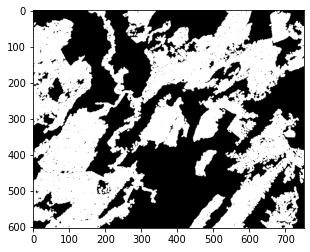

In [107]:
img_floodfill = disk2_img.copy()

img_floodfill, labels = label(img_floodfill, return_num=True)

threshold = min(2000, img_floodfill.shape[0] / 20 * img_floodfill.shape[1] / 20)
for i in range(1, labels):
    if np.sum(img_floodfill == i) < threshold:
        img_floodfill[img_floodfill == i] = 0

img_floodfill[img_floodfill != 0] = 255

_ = plt.imshow(img_floodfill, cmap='gray')
img_floodfill.shape, threshold

In [108]:
np.unique(img_floodfill)

array([  0, 255])

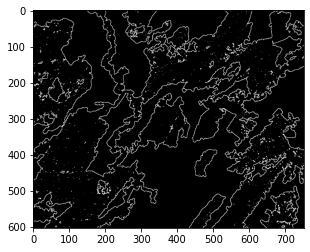

In [113]:
laplacian_filter = np.array([
    [1,  1, 1],
    [1, -8, 1],
    [1,  1, 1]
], np.int8)

edge = np.zeros(img_floodfill.shape)
padded = np.pad(img_floodfill, 1, 'edge')

for i in range(img_floodfill.shape[0]):
    for j in range(img_floodfill.shape[1]):
        edge[i, j] = np.sum(padded[i : i + 3, j : j + 3] * laplacian_filter)

edge = np.clip(edge, 0, 1) * 255

plt.imshow(edge, cmap='gray')

In [110]:
img_final.shape, edge.shape

((604, 752, 3), (604, 752))

True

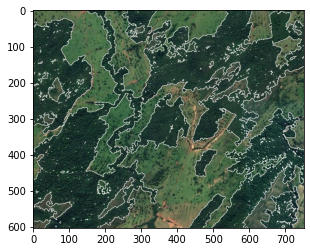

In [111]:
img_final = img.copy()

img_final[edge == 255, :] = 255

plt.imshow(img_final)
cv2.imwrite('final.png', cv2.cvtColor(img_final, cv2.COLOR_BGR2RGB))

In [112]:
print(np.sum(img_floodfill) / 255 * metro2_por_pixel / 10000)

231.11